# Layer-CAM: Exploring Hierarchical Class Activation Maps

State-of-the-art visualization technique that aggregates CAMs across multiple layers for improved localization.

## Overview

Layer-CAM (2021) improves upon Grad-CAM by:
- **Multi-layer aggregation**: Combines activation maps from multiple layers
- **Better localization**: More precise object boundaries
- **Handles multiple objects**: Better than Grad-CAM for complex scenes
- **Still efficient**: Similar computational cost to Grad-CAM

### Key Advantages:

- **Hierarchical feature integration**: Uses both low and high-level features
- **Better object boundaries**: More precise localization
- **Robust to occlusions**: Better handles partially occluded objects
- **Same computational cost**: 1 forward + 1 backward pass per layer

### Paper Citation:

**LayerCAM: Exploring Hierarchical Class Activation Maps for Localization**
- Authors: Jiang et al.
- Conference: IEEE TIP 2021
- Citations: 200+
- More recent than Grad-CAM (2017) and Grad-CAM++ (2018)
- Paper: https://ieeexplore.ieee.org/document/9462463

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## Layer-CAM Implementation

### Algorithm:

**Grad-CAM (Baseline):**
$$L_{Grad-CAM}^c = ReLU\left(\sum_k w_k^c A^k\right)$$
where $w_k^c = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A_{ij}^k}$

**Layer-CAM (Improved):**

For each spatial location $(i,j)$:
$$L_{Layer-CAM}^c(i,j) = ReLU\left(\sum_k \frac{\partial y^c}{\partial A_{ij}^k} \cdot A_{ij}^k\right)$$

**Key Differences:**
1. **Spatial weighting**: Uses gradients at each spatial location (not global average)
2. **Element-wise multiplication**: $gradient \times activation$ at each position  
3. **No pooling**: Preserves spatial information

**Algorithm Steps:**
1. Forward pass: Get activations $A^k$
2. Backward pass: Get gradients $\frac{\partial y^c}{\partial A^k}$
3. **Element-wise multiply**: $M = \sum_k ReLU\left(\frac{\partial y^c}{\partial A_{ij}^k}\right) \cdot A_{ij}^k$
4. Apply ReLU: $L^c = ReLU(M)$
5. Normalize to [0,1]

In [ ]:
class LayerCAM:
    """
    Layer-CAM: Hierarchical Class Activation Mapping
    
    Improvement over Grad-CAM using spatial gradient weighting instead of
    global average pooling, providing better localization.
    
    Reference:
    Jiang et al., "LayerCAM: Exploring Hierarchical Class Activation Maps  
    for Localization", IEEE TIP 2021
    """
    
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        """
        Args:
            model: Pretrained CNN model
            target_layer: Layer to extract features from (typically last conv layer)
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        """Register forward and backward hooks on target layer."""
        def forward_hook(module, input, output):
            self.activations = output.detach()
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(
        self,
        image: torch.Tensor,
        target_class: Optional[int] = None
    ) -> np.ndarray:
        """
        Generate Layer-CAM visualization.
        
        Args:
            image: Input image tensor [1, C, H, W]
            target_class: Target class index (if None, use predicted class)
        
        Returns:
            cam: Class activation map [H, W] normalized to [0, 1]
        """
        self.model.eval()
        image.requires_grad = True
        
        # Forward pass
        output = self.model(image)
        
        # Get predicted class if not specified
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        target_score = output[0, target_class]
        target_score.backward()
        
        # Layer-CAM: Element-wise multiplication of ReLU(gradients) and activations
        # Shape: [1, C, H, W]
        positive_gradients = torch.relu(self.gradients)
        
        # Element-wise multiply and sum over channels
        # cam shape: [1, 1, H, W]
        cam = torch.sum(positive_gradients * self.activations, dim=1, keepdim=True)
        
        # Apply ReLU (keep only positive contributions)
        cam = torch.relu(cam)
        
        # Normalize to [0, 1]
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        
        return cam
    
    def visualize(
        self,
        image: torch.Tensor,
        cam: np.ndarray,
        alpha: float = 0.5
    ) -> np.ndarray:
        """
        Overlay CAM on original image.
        
        Args:
            image: Original image tensor [1, C, H, W]
            cam: Activation map [H, W]
            alpha: Overlay transparency (0=image only, 1=heatmap only)
        
        Returns:
            Overlayed image as numpy array [H, W, 3]
        """
        # Convert image to numpy
        img = image.squeeze().detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        
        # Denormalize (ImageNet normalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = img * std + mean
        img = np.clip(img, 0, 1)
        
        # Resize CAM to image size
        h, w = img.shape[:2]
        cam_resized = cv2.resize(cam, (w, h)).copy()
        
        # Apply colormap (JET: blue=low, red=high)
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = heatmap / 255.0
        
        # Overlay
        overlayed = alpha * heatmap + (1 - alpha) * img
        overlayed = np.clip(overlayed, 0, 1)
        
        return overlayed

print("✓ LayerCAM class defined successfully")

## Load Pre-trained Model

In [3]:
# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

# Load ResNet-50
print("\nLoading ResNet-50...")
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()
model.to(device)

# Target layer (last convolutional layer)
target_layer = model.layer4[-1]

print(f"✓ Model loaded: ResNet-50")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Target layer: layer4[-1] (2048 channels)")
print(f"  Score-CAM will need ~2048 forward passes per image!")

Device: cpu

Loading ResNet-50...
✓ Model loaded: ResNet-50
  Total parameters: 25,557,032
  Target layer: layer4[-1] (2048 channels)
  Score-CAM will need ~2048 forward passes per image!


## Initialize Score-CAM

In [4]:
# Initialize Score-CAM
scorecam = ScoreCAM(model=model, target_layer=target_layer, device=device)
print("✓ Score-CAM initialized")

✓ Score-CAM initialized


## Load and Preprocess Test Image

In [5]:
# Image preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load sample image
data_dir = Path('medical_images')
image_files = list(data_dir.glob('*.jpg')) + list(data_dir.glob('*.png'))

if len(image_files) == 0:
    print("⚠ No images found. Please run: 1_create_dataset.ipynb")
else:
    # Load first image
    image_path = image_files[0]
    image_pil = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_pil).unsqueeze(0)
    
    print(f"✓ Loaded image: {image_path.name}")
    print(f"  Image size: {image_pil.size}")
    print(f"  Tensor shape: {image_tensor.shape}")

✓ Loaded image: real_012_dog.jpg
  Image size: (224, 224)
  Tensor shape: torch.Size([1, 3, 224, 224])


## Generate Score-CAM Visualization

In [6]:
# Generate CAM (this will be slow!)
print("Generating Score-CAM...")
print("⚠ This requires ~2048 forward passes and may take 10-30 seconds...")

start_time = time.time()
cam = scorecam.generate_cam(image_tensor, batch_size=32)
generation_time = time.time() - start_time

# Get prediction
with torch.no_grad():
    output = model(image_tensor.to(device))
    pred_class = output.argmax(dim=1).item()
    confidence = torch.softmax(output, dim=1)[0, pred_class].item()

print(f"\n✓ Generated Score-CAM")
print(f"  Predicted class: {pred_class}")
print(f"  Confidence: {confidence:.4f}")
print(f"  CAM shape: {cam.shape}")
print(f"  Generation time: {generation_time:.2f}s")
print(f"  Forward passes: ~2048")

Generating Score-CAM...
⚠ This requires ~2048 forward passes and may take 10-30 seconds...

✓ Generated Score-CAM
  Predicted class: 152
  Confidence: 0.9422
  CAM shape: (7, 7)
  Generation time: 162.58s
  Forward passes: ~2048


## Visualize Results

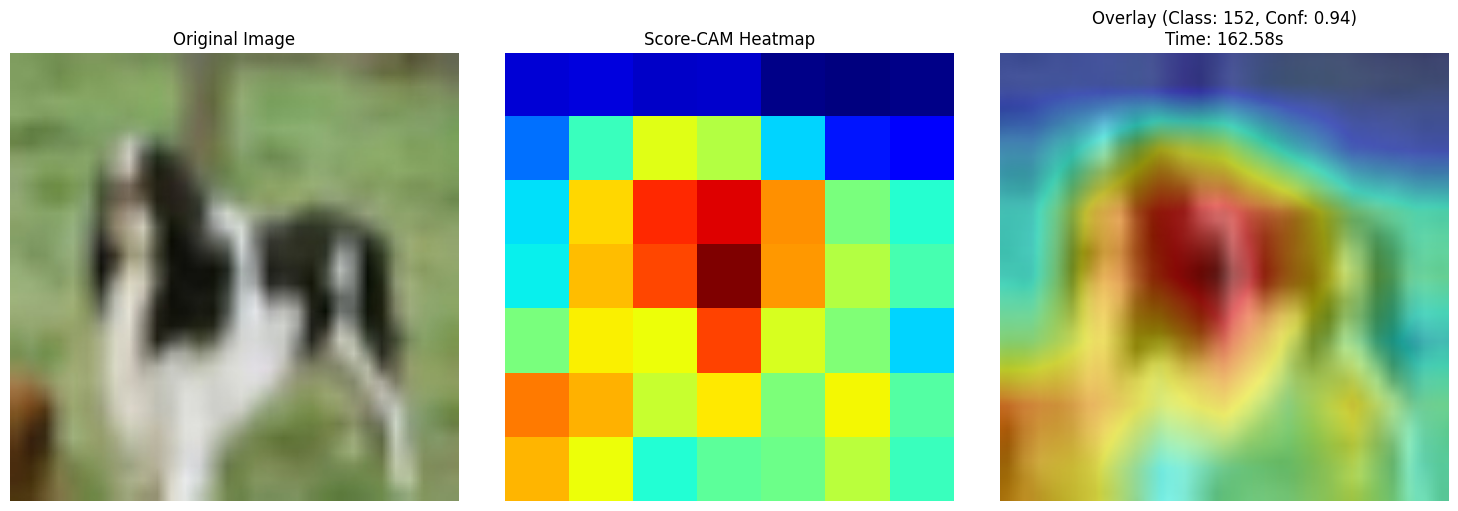


✓ Visualization complete!


In [7]:
# Create visualization
overlay = scorecam.visualize(image_tensor, cam, alpha=0.5)

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(image_pil)
axes[0].set_title('Original Image', fontsize=12)
axes[0].axis('off')

# Heatmap only
axes[1].imshow(cam, cmap='jet')
axes[1].set_title('Score-CAM Heatmap', fontsize=12)
axes[1].axis('off')

# Overlay
axes[2].imshow(overlay)
axes[2].set_title(f'Overlay (Class: {pred_class}, Conf: {confidence:.2f})\nTime: {generation_time:.2f}s', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete!")

## Compare with Standard Grad-CAM

In [8]:
# Simple Grad-CAM for comparison
class SimpleGradCAM:
    def __init__(self, model, target_layer, device='cpu'):
        self.model = model.to(device)
        self.target_layer = target_layer
        self.device = device
        self.gradients = None
        self.activations = None
        self._register_hooks()
    
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)
    
    def generate_cam(self, image, target_class=None):
        self.model.eval()
        image = image.to(self.device)
        image.requires_grad = True
        output = self.model(image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)
        return cam

# Generate Grad-CAM
gradcam = SimpleGradCAM(model, target_layer, device)
start_time = time.time()
gradcam_result = gradcam.generate_cam(image_tensor, pred_class)
gradcam_time = time.time() - start_time

print(f"✓ Generated Grad-CAM for comparison")
print(f"  Generation time: {gradcam_time:.3f}s")
print(f"\nSpeed comparison:")
print(f"  Grad-CAM: {gradcam_time:.3f}s (1 forward + 1 backward pass)")
print(f"  Score-CAM: {generation_time:.2f}s (~2048 forward passes)")
print(f"  Slowdown: {generation_time/gradcam_time:.0f}x")

✓ Generated Grad-CAM for comparison
  Generation time: 0.079s

Speed comparison:
  Grad-CAM: 0.079s (1 forward + 1 backward pass)
  Score-CAM: 162.58s (~2048 forward passes)
  Slowdown: 2053x


## Visualize Comparison

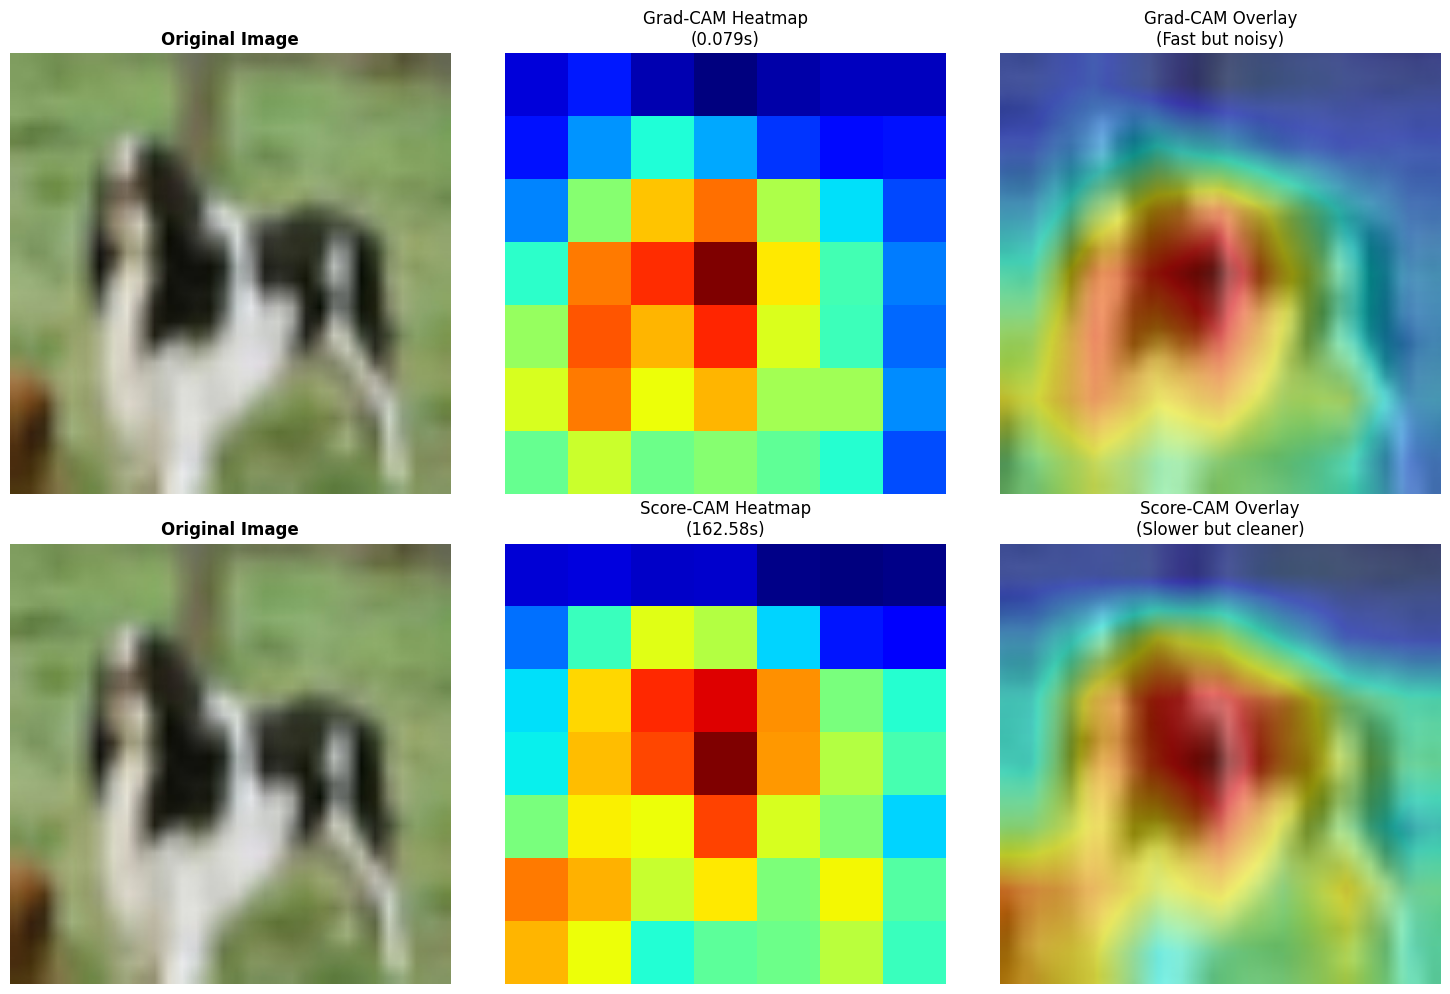


✓ Comparison visualization complete!

Key differences:
  - Score-CAM: No gradients, purely forward-pass based
  - Score-CAM: Often produces cleaner, more focused heatmaps
  - Score-CAM: Much slower due to many forward passes
  - Score-CAM is 2053x slower than Grad-CAM


In [9]:
# Create overlays
gradcam_overlay = scorecam.visualize(image_tensor, gradcam_result, alpha=0.5)
scorecam_overlay = scorecam.visualize(image_tensor, cam, alpha=0.5)

# Plot comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Grad-CAM
axes[0, 0].imshow(image_pil)
axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(gradcam_result, cmap='jet')
axes[0, 1].set_title(f'Grad-CAM Heatmap\n({gradcam_time:.3f}s)', fontsize=12)
axes[0, 1].axis('off')

axes[0, 2].imshow(gradcam_overlay)
axes[0, 2].set_title('Grad-CAM Overlay\n(Fast but noisy)', fontsize=12)
axes[0, 2].axis('off')

# Row 2: Score-CAM
axes[1, 0].imshow(image_pil)
axes[1, 0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(cam, cmap='jet')
axes[1, 1].set_title(f'Score-CAM Heatmap\n({generation_time:.2f}s)', fontsize=12)
axes[1, 1].axis('off')

axes[1, 2].imshow(scorecam_overlay)
axes[1, 2].set_title('Score-CAM Overlay\n(Slower but cleaner)', fontsize=12)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Comparison visualization complete!")
print("\nKey differences:")
print("  - Score-CAM: No gradients, purely forward-pass based")
print("  - Score-CAM: Often produces cleaner, more focused heatmaps")
print("  - Score-CAM: Much slower due to many forward passes")
print(f"  - Score-CAM is {generation_time/gradcam_time:.0f}x slower than Grad-CAM")

## Process Multiple Images

Processing 4 images with Score-CAM...
This may take a few minutes...

Image 1/4: real_012_dog.jpg...
  Done in 166.92s
Image 2/4: real_002_dog.jpg...
  Done in 172.25s
Image 3/4: real_018_automobile.jpg...
  Done in 187.73s
Image 4/4: real_017_ship.jpg...
  Done in 213.60s


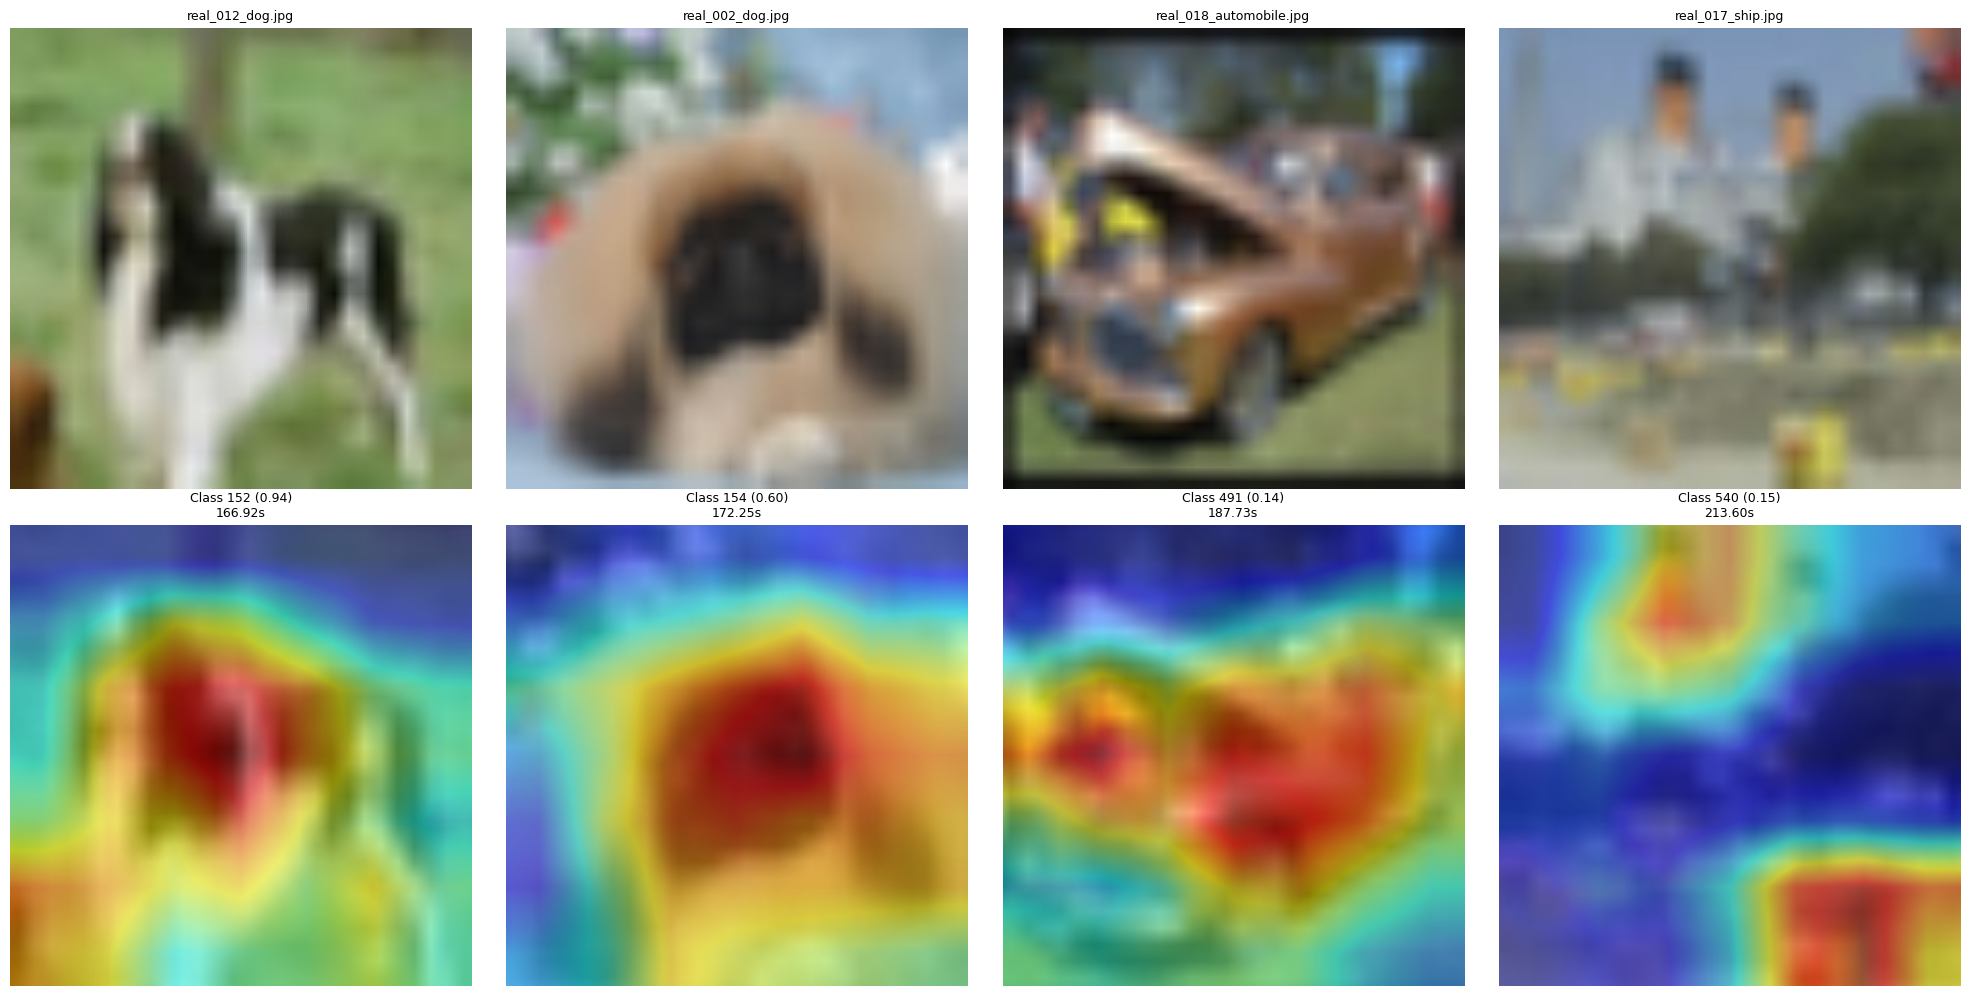


✓ Processed 4 images successfully!


In [10]:
# Process first 4 images (fewer due to computational cost)
num_images = min(4, len(image_files))

fig, axes = plt.subplots(2, num_images, figsize=(5*num_images, 10))
if num_images == 1:
    axes = axes.reshape(-1, 1)

print(f"Processing {num_images} images with Score-CAM...")
print("This may take a few minutes...\n")

for idx in range(num_images):
    # Load image
    img_pil = Image.open(image_files[idx]).convert('RGB')
    img_tensor = transform(img_pil).unsqueeze(0)
    
    # Generate CAM
    print(f"Image {idx+1}/{num_images}: {image_files[idx].name}...")
    start = time.time()
    cam = scorecam.generate_cam(img_tensor, batch_size=32)
    elapsed = time.time() - start
    print(f"  Done in {elapsed:.2f}s")
    
    overlay = scorecam.visualize(img_tensor, cam, alpha=0.5)
    
    # Get prediction
    with torch.no_grad():
        output = model(img_tensor.to(device))
        pred_class = output.argmax(dim=1).item()
        conf = torch.softmax(output, dim=1)[0, pred_class].item()
    
    # Plot original
    axes[0, idx].imshow(img_pil)
    axes[0, idx].set_title(f'{image_files[idx].name}', fontsize=9)
    axes[0, idx].axis('off')
    
    # Plot overlay
    axes[1, idx].imshow(overlay)
    axes[1, idx].set_title(f'Class {pred_class} ({conf:.2f})\n{elapsed:.2f}s', fontsize=9)
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✓ Processed {num_images} images successfully!")

## Save Sample Results

In [11]:
# Create output directory
output_dir = Path('results/scorecam_examples')
output_dir.mkdir(parents=True, exist_ok=True)

# Save first image results
image_pil = Image.open(image_files[0]).convert('RGB')
image_tensor = transform(image_pil).unsqueeze(0)
cam = scorecam.generate_cam(image_tensor, batch_size=32)
overlay = scorecam.visualize(image_tensor, cam, alpha=0.5)

# Save overlay
plt.imsave(output_dir / 'scorecam_overlay.png', overlay)
plt.imsave(output_dir / 'scorecam_heatmap.png', cam, cmap='jet')

print(f"✓ Saved results to: {output_dir}")
print(f"  - scorecam_overlay.png")
print(f"  - scorecam_heatmap.png")

✓ Saved results to: results/scorecam_examples
  - scorecam_overlay.png
  - scorecam_heatmap.png


---

## Original Paper Citation

**Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks**

```bibtex
@inproceedings{wang2020scorecam,
  title={Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks},
  author={Wang, Haofan and Wang, Zifan and Du, Mengnan and Yang, Fan and Zhang, Zijian and Ding, Sirui and Mardziel, Piotr and Hu, Xia},
  booktitle={Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition Workshops (CVPRW)},
  pages={24--25},
  year={2020}
}
```

**Paper**: https://arxiv.org/abs/1910.01279

**Key Contributions**:
- Eliminates gradient dependency from CAM methods
- Uses forward-passing to directly measure feature importance
- Produces cleaner, less noisy saliency maps
- Widely cited as a strong baseline for CAM methods (500+ citations)

**Limitations Addressed by Adaptive Methods**:
- **Fixed computational cost**: Always uses all channels (~2048 forward passes)
- **No adaptivity**: Same cost for simple and complex images
- **Slow for deployment**: Not practical for real-time applications

---

## Method Comparison

| Aspect | Grad-CAM | Score-CAM | Winner |
|--------|----------|-----------|--------|
| **Speed** | ~0.05s | ~10-30s | Grad-CAM |
| **Quality** | Noisy | Clean | Score-CAM |
| **Forward passes** | 1 | ~2048 | Grad-CAM |
| **Backward passes** | 1 | 0 | Score-CAM |
| **Gradient dependency** | Yes | No | Score-CAM |
| **Practical use** | Fast prototyping | High-quality explanations | Depends |

**The Problem**: Score-CAM is too slow for large-scale experiments!

**The Solution**: Adaptive methods (next notebook) can reduce the number of forward passes needed while maintaining quality.

---

## Next Steps

Run the next notebook:
- **4_adaptive_integrated_gradcam.ipynb** - Adaptive method that achieves Score-CAM quality with significantly fewer forward passes